In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

This notebook implements the skewed t-distribution described by Jones & Faddy (2003):
    
Jones, M., Faddy, M. (2003). A skew extension of the t-distribution, with applications Journal of the Royal Statistical Society: Series B (Statistical Methodology)  65(1), 159-174. https://dx.doi.org/10.1111/1467-9868.00378

The skewed t-distribution described by Jones & Faddy (2003) is given in Eq. 1 of their paper as:

$$ f(t;a,b) =  \frac{2^{1-a-b}}{\sqrt{a+b}}\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)} \left[1 + \frac{t}{\sqrt{a+b+t^2}} \right]^{a+1/2} \left[ 1 - \frac{t}{\sqrt{a+b+t^2}} \right]^{b+1/2}$$

This distribution is defined by two parameters $a,b > 0$. The Cauchy distribution is recovered when $a = b = 1/2$. The Normal distribution is recovered in the limit $a = b \to \infty$. 

An important advantage of this formulation, as opposed to other skewed t-distributions that have been proposed in the literature, is that the mode has a simple analytical form, givem by

$$ t^* = \frac{(a-b)\sqrt{a+b}}{\sqrt{2a+1}\sqrt{2b+1}}. $$

This allows us to position the mode of the likelihood distribution $p(y|\hat{y})$ exactly at $\hat{y}$, something that seems desirable from an intuitive standpoint. Specificaly, positioning the mode of this distribution at $\hat{y}$, and rescaling this distribution according to a y-scale $s$, the likelihood becomes:

$$ p(y|\hat{y};s,a,b) = s^{-1} f(t;a,b)~~~\mathrm{where}~~~t=t^*+(y-\hat{y})/s$$

The last cell of this notebook sketches a SkewedTNoiseModel layer in which the parameters $a$, $b$, and $s$ are trainable.

In [2]:
from scipy.special import beta as Beta
from scipy.special import gamma as Gamma
from scipy.special import gammaln as LogGamma
from numpy import log as Log

# First compute log PDF to avoid overflow problems
def log_f(t,a,b):
    arg = t/np.sqrt(a+b+t**2)
    return (1-a-b)*Log(2) + \
           -0.5*Log(a+b) + \
           LogGamma(a+b) + \
           -LogGamma(a) + \
           -LogGamma(b) + \
           (a+0.5)*Log(1+arg) + \
           (b+0.5)*Log(1-arg) 
           
# Exponentiate to get true distribution
def f(t,a,b):
    return np.exp(log_f(t,a,b))

# Compute the mode as a function of a and b
def t_mode(a,b):
    return (a-b)*np.sqrt(a+b)/(np.sqrt(2*a+1)*np.sqrt(2*b+1))

# Compute mean
def t_mean(a,b):
    if a <= 0.5 or b <= 0.5:
        return np.nan
    else:
        return 0.5*(a-b)*np.sqrt(a+b)*np.exp(LogGamma(a-0.5) + LogGamma(b-0.5) - LogGamma(a) - LogGamma(b))

# Compute variance
def t_std(a,b):
    if a <= 1 or b <= 1:
        return np.nan
    else:
        t_expected = t_mean(a,b)
        tsq_expected = 0.25*(a+b)*((a-b)**2+(a-1)+(b-1))/((a-1)*(b-1))
        return np.sqrt(tsq_expected - t_expected**2)
    
def p(y,y_mode,y_scale,a,b):
    t = t_mode(a,b) + (y-y_mode)/y_scale
    return f(t,a,b)/y_scale

def p_mean_std(y_mode, y_scale, a, b):
    y_mean = t_mean(a,b)*y_scale + y_mode
    y_std = t_std(a,b)*y_scale
    return y_mean, y_std

a=0.5, b=0.5
y_mean=nan, y_std=nan
Area under the distribution is 1.00000 (+-1.1282e-08)
a=2.5, b=0.5
y_mean=nan, y_std=nan
Area under the distribution is 1.00000 (+-1.4354e-10)
a=4.5, b=0.5
y_mean=nan, y_std=nan
Area under the distribution is 1.00000 (+-1.0202e-11)
a=6.5, b=0.5
y_mean=nan, y_std=nan
Area under the distribution is 1.00000 (+-1.3042e-10)
a=8.5, b=0.5
y_mean=nan, y_std=nan
Area under the distribution is 1.00000 (+-3.9865e-09)


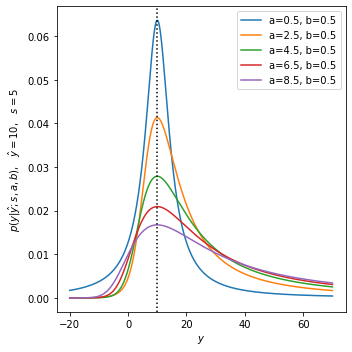

In [3]:
# Set y coords
y_scale=5
y_mode=10
y_lb = -20
y_ub = +70
ys = np.linspace(y_lb, y_ub, 1000)

# Plot distributions
fig, ax = plt.subplots(figsize=[5,5])
for k in range(5):
    b = 0.5
    a = 0.5+2*k
    dist = lambda y: p(y,y_mode=y_mode, y_scale=y_scale, a=a, b=b)
    label = f'a={a:.1f}, b={b:.1f}'
    ax.plot(ys, dist(ys), label=label)
    print(label)
    
    # Compute mean and std:
    mean, std = p_mean_std(y_mode, y_scale, a, b)
    print(f'y_mean={mean:.2f}, y_std={std:.2f}')
    
    # Check normalization
    res, err = quad(dist, -np.inf, np.inf)
    print(f"Area under the distribution is {res:.5f} (+-{err:.5g})")

# Show median
ax.axvline(y_mode, color='k', linestyle=':')
ax.legend()
ax.set_xlabel('$y$')
ax.set_ylabel('$p(y|\hat{y};s,a,b)$,   $\hat{y}=%d$,   $s=%d$'%(y_mode, y_scale))
fig.tight_layout()

fig.savefig('skewed_t.png')

It is useful to also provide the user with confidence intervals. These can be computed using the relation

$$ F(t; a,b) = I_x(a,b)$$

where $I_x(a,b)$ is the incomplete beta function and $x \in (0,1)$ is defined in terms of $t$ by

$$ x = \frac{1}{2}\left(1 + \frac{t}{\sqrt{a+b+t^2}}\right)~~~\Leftrightarrow~~~t = \frac{(2x-1)\sqrt{a+b}}{\sqrt{1 - (2x-1)^2}}.$$

So if given a quantile $q \in (0,1)$, the corresponding value of $y$ will be

$$ y_q = (t_q-t^*)s + \hat{y},$$
where
$$ t_q = \frac{(2x_q-1)\sqrt{a+b}}{\sqrt{1 - (2x_q-1)^2}}, $$
and $x_q$ solves $q = I_{x_q}(a,b)$. Fortunately, scipy has a function for the inverse of the incomplete beta function (scipy.special.betaincinv), and so this can all be computed directly without any numerical optimization. Here we demonstrate this:


Area to the left of quantile 0.025 is 0.02500 (+-5.1166e-09)
Area to the left of quantile 0.160 is 0.16000 (+-1.5014e-12)
Area to the left of quantile 0.500 is 0.50000 (+-1.1394e-08)
Area to the left of quantile 0.840 is 0.84000 (+-1.4213e-08)
Area to the left of quantile 0.975 is 0.97500 (+-2.563e-10)


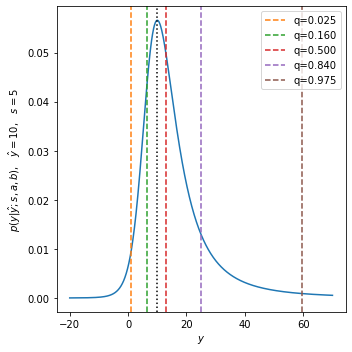

In [18]:
from scipy.special import betaincinv as BetaIncInv

def t_quantile(q,a,b):
    x_q = BetaIncInv(a,b,q)
    t_q = (2*x_q-1)*np.sqrt(a+b)/np.sqrt(1-(2*x_q-1)**2)
    return t_q

def y_quantile(q, y_hat, s, a, b):
    t_q = t_quantile(q, a, b)
    y_q = (t_q - t_mode(a,b))*s + y_hat
    return y_q

# Set y coords
y_scale=5
y_mode=10
y_lb = -20
y_ub = +70
ys = np.linspace(y_lb, y_ub, 1000)

# Plot distributions
fig, ax = plt.subplots(figsize=[5,5])

b = 1
a = 3
dist = lambda y: p(y,y_mode=y_mode, y_scale=y_scale, a=a, b=b)
ax.plot(ys, dist(ys))

for i, q in enumerate([.025,.16,.50,.84,.975]):

    # Compute quantiles
    y_q = y_quantile(q, y_mode, y_scale, a, b)
    color = f'C{i+1:d}'
    ax.axvline(y_q, linestyle='--', label=f'q={q:.3f}', color=color)
    
    # Check normalization
    res, err = quad(dist, -np.inf, y_q)
    print(f"Area to the left of quantile {q:.3f} is {res:.5f} (+-{err:.5g})")
    
# Show median
ax.axvline(y_mode, color='k', linestyle=':')
ax.legend()
ax.set_xlabel('$y$')
ax.set_ylabel('$p(y|\hat{y};s,a,b)$,   $\hat{y}=%d$,   $s=%d$'%(y_mode, y_scale))
fig.tight_layout()

fig.savefig('skewed_t.png')

In [ ]:
# Compute p,q in terms of a,b according to Eq. 7 in Jones and Faddy
def ab_to_pq(a,b):
    assert a > 0
    assert b > 0
    p = 2/(a+b)
    q = (a-b)/np.sqrt(a*b*(a+b))
    return p,q

# Compue a,b in terms of p,q (had to derive this; took a while)
def pq_to_ab(p,q):
    assert p > 0
    a = (1/p)*(1+q/np.sqrt(q**2+2*p))
    b = (1/p)*(1-q/np.sqrt(q**2+2*p))
    return a,b

# test:
a=10
b=2
print(f'a={a}, b={b}')

p,q = ab_to_pq(a,b)
print(f'p={p}, q={q}')

a,b = pq_to_ab(p,q)
print(f'a={a}, b={b}')

In [ ]:
import tensorflow as tf
from tensorflow import keras

# To clarify equations
Log = tf.math.log
LogGamma = tf.math.lgamma
Exp = tf.math.exp
Sqrt = tf.math.sqrt
Square = tf.math.square

class SkewedTNoiseModel(keras.layers.Layer):
    """
    Inputs consit of y and y_hat.
    Outputs consist of negative log likelihood values.
    Computes likelihood using the skewed t-distribution proposed by Jones and Faddy (2003). 
    Layer includes three trainable scalar weights: log_a, log_b, and log_scale.
    """

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "log_a":self.log_a, "log_b":self.log_b, "log_scale":self.log_scale}
    
    def build(self, batch_input_shape):

        # Create trainable weights
        self.log_a = self.add_weight(name="log_a", trainable=True, initializer="zeros")
        self.log_b = self.add_weight(name="log_b", trainable=True, initializer="zeros")
        self.log_scale = self.add_weight(name="log_scale", trainable=True, initializer="zeros")
        
        # Continue building keras.laerys.Layer class
        super.build(batch_input_shape)
    
    def call(self, y, y_hat):
        
        # Compute a, b, scale in terms of trainable parameters
        self.a = Exp(self.log_a)
        self.b = Exp(self.log_b)
        self.scale = Exp(self.log_scale)
        
        # Compute the mode of the unscaled, unshifted t-distribution
        self.t_mode = (self.a-self.b)*Sqrt(self.a+self.b)/(Sqrt(2*self.a+1)*Sqrt(2*self.b+1))

        # Compute the t value corresponding to y, assuming the mode is at y_hat
        t = self.t_mode + (y-y_hat)/self.scale
    
        # Compute useful argument
        arg = t/Sqrt(self.a+self.b+Square(t))
        
        # Compute the log likelihood of y given y_hat and return
        log_likelihood = (self.a+0.5)*Log(1+arg) + \
                         (self.b+0.5)*Log(1-arg) + \
                         -(self.a+self.b-1)*Log(2) + \
                         -0.5*Log(self.a+self.b) + \
                         LogGamma(self.a+self.b) + \
                         -LogGamma(self.a) + \
                         -LogGamma(self.b) + \
                         -self.log_scale
        return -log_likelihood
